## MLC HW 4

### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

2) The log marginal likelihood of the training data. (5 pts)

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)


In [1]:
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
import pandas as pd
import numpy as np
np.random.seed(42)
#Loading the data
Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head()


,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


In [3]:
#Normalize the data and create a seperate column
Data1['Normalized_DailyTrafficCount'] = np.log(Data1['AvgDailyTrafficCount'])
Data1['Normalized_DailyTrafficCount'] = Data1['Normalized_DailyTrafficCount']-np.mean(Data1['Normalized_DailyTrafficCount'])

Data1.head()



,Longitude,Latitude,AvgDailyTrafficCount,Normalized_DailyTrafficCount
0,-80.278366,40.468606,84.0,-3.977526
1,-80.162117,40.384598,95.0,-3.854466
2,-80.221205,40.366778,97.0,-3.833632
3,-80.142455,40.622084,111.0,-3.698812
4,-80.131975,40.544915,125.0,-3.580029


In [4]:
#Building a good kernel
#From professor notes

#1 The kernel after parameter optimization and fitting to the observed data
kernel = 1.* RBF(length_scale=1., length_scale_bounds=(1e-3, 1e3)) + WhiteKernel(noise_level=1., noise_level_bounds=(1e-10, 1e10))

gp = GaussianProcessRegressor(kernel=kernel,random_state=42)


# Fiting to data
gp.fit(Data1.iloc[:,0:2], Data1.Normalized_DailyTrafficCount)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=42)

In [5]:
xmin, xmax = min(Data1.Longitude), max(Data1.Longitude)
ymin, ymax = min(Data1.Latitude), max(Data1.Latitude)
xx, yy = np.meshgrid(np.linspace(xmin, xmax),
                     np.linspace(ymin, ymax))

In [6]:
yy.shape

(50, 50)

In [7]:
#2
print('The log marginal likelihood of the training data: \n{}'.format(gp.log_marginal_likelihood_value_))

The log marginal likelihood of the training data: 
-1365.9466919139297


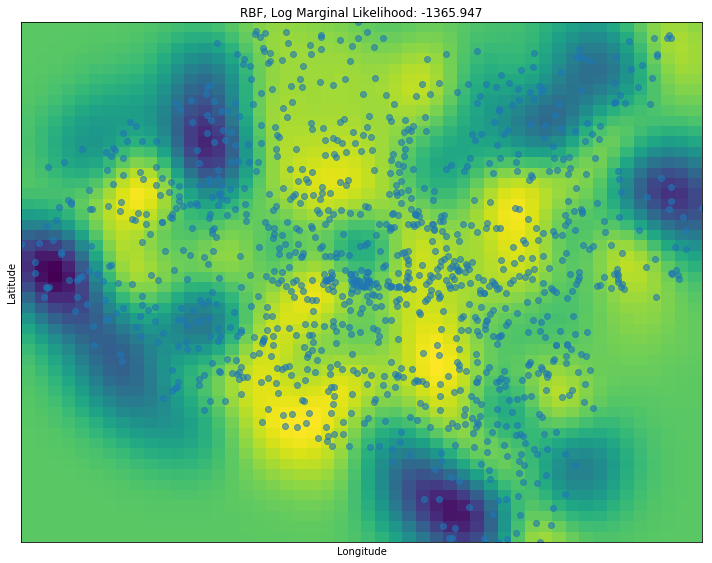

In [8]:
#3

#Showing a 2-D plot of the model's predictions over a mesh grid of longitude/latitude
#(with color corresponding to the model's predictions)
#and overlaying a 2-D scatter plot of sensor locations (with color corresponding to the observed values)

#From professor lab notes

plt.figure(figsize=(10, 10))

plt.subplot(1, 1, 1)
Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])

# color plot
Z = Z.reshape((xx.shape[0], xx.shape[1]))
plt.imshow(Z, extent=(xmin, xmax, ymin, ymax), origin="lower",cmap='viridis')

# Plotting also the training points
plt.scatter(Data1.iloc[:,0],Data1.iloc[:,1], cmap='viridis',alpha=0.6)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title("%s, Log Marginal Likelihood: %.3f" %
          ("RBF", gp.log_marginal_likelihood(gp.kernel_.theta)))


plt.tight_layout()
plt.show()

### Figure1: 2-D plot of the model's predictions over a mesh grid of longitude/latitude and 2-D scatter plot of sensor locations (with color corresponding to the observed values)

In [9]:
Data1['Predicted_TrafficCount'] = gp.predict(Data1[['Longitude', 'Latitude']])

stdv = Data1['Predicted_TrafficCount'].std()
Data1['2STDS'] = (Data1['Normalized_DailyTrafficCount'] - Data1['Predicted_TrafficCount']) / (2 * stdv)
Data1['2STDS'] = [1 if i > 2 else -1 if i < -2 else 0 for i in Data1['2STDS']]
Data1.head()


,Longitude,Latitude,AvgDailyTrafficCount,Normalized_DailyTrafficCount,Predicted_TrafficCount,2STDS
0,-80.278366,40.468606,84.0,-3.977526,-1.594040,-1
1,-80.162117,40.384598,95.0,-3.854466,-0.800837,-1
2,-80.221205,40.366778,97.0,-3.833632,-1.246781,-1
3,-80.142455,40.622084,111.0,-3.698812,-1.251590,-1
4,-80.131975,40.544915,125.0,-3.580029,-1.326580,-1


In [10]:
#4

total_count = Data1['2STDS'].count()
two_stdevs_lower = Data1[Data1['2STDS'] == -1]['2STDS'].count()
two_stdevs_higher = Data1[Data1['2STDS'] == 1]['2STDS'].count()
print('Percentage of sensors having average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location: {0:.3f}%'
      .format(100 * (two_stdevs_lower + two_stdevs_higher) / total_count))

Percentage of sensors having average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location: 1.435%


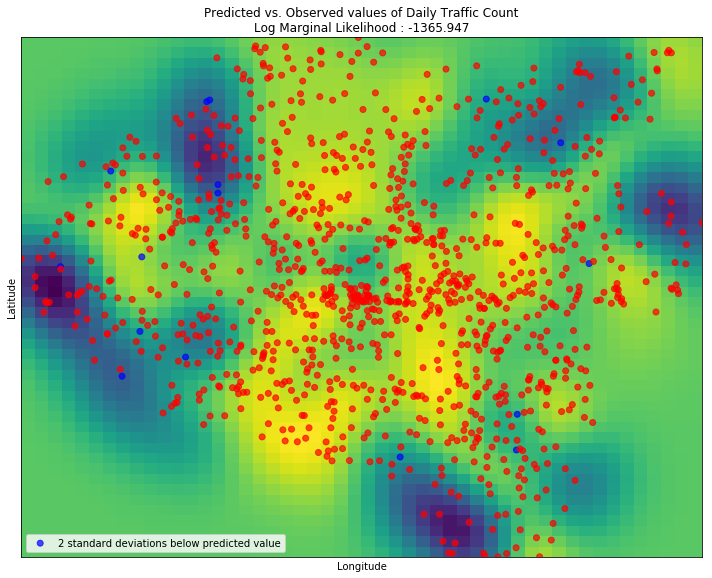

In [11]:
#5

#Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values
#a) more than two standard deviations higher than predicted, b) more than
#two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. 

plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape((xx.shape[0], xx.shape[1]))
plt.imshow(Z, extent=(xmin, xmax, ymin, ymax), origin="lower", cmap='viridis')

# Plot also the training points
plt.scatter(Data1['Longitude'], Data1['Latitude'], 
            c=np.array(["r", "g", "b"])[Data1['2STDS']], alpha=0.7, label='2 standard deviations below predicted value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Predicted vs. Observed values of Daily Traffic Count\nLog Marginal Likelihood : {0:.3f}'\
          .format(gp.log_marginal_likelihood_value_))
plt.legend(loc=3)

plt.tight_layout()
plt.show()

### Figure 2: 2-D scatter plot of the sensor locations, with three colors corresponding to observed values:

#### a) more than two standard deviations higher than predicted,
#### b) more than two standard deviations lower than predicted, and 
#### c) within two standard deviations of the predicted values. 

### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 2 points, center (15, 20), standard deviation 1

D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		Anomaly / Not Anomaly : Anomaly

If we refer to global density anomaly detection, (1,0) is very close to a dense pack, and hence is not anomalous. But if we see through local-based anomaly detection method, the point falls 10 std outside of the cluster center, and hence is anomalous.

(35, 2)		Anomaly / Not Anomaly : Not Anomaly

Since the std is 5, this cluster is less dense, and thus is likely to fall within one std of the cluster center, and hence is not an anomaly.

(15, 19)	Anomaly / Not Anomaly : Anomaly

This point is also within one std of the cluster center like the point in part B, but since the cluster is too small (that it has only 2 points), the points in this small cluster are likely to be anomalous (considering that the other clusters are larger)

(10, 11)	Anomaly / Not Anomaly : Not Anomaly

This point is within 1 std of the cluster center (fairly dense) and hence is not likely to be anomalous.




### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [12]:
#Reading the data
Data2=pd.read_csv("2016CountyHealthIndicators.csv").replace('?', "nan").set_index('County').astype(float)
Data2.head()

,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
County,,,,,,,,,,,,,,,,,,,,,
"Autauga, Alabama",19.0,4.4,4.3,9.0,19.0,31.0,7.1,29.0,71.0,15.0,...,18.0,4.3,27.0,13.8,254.0,76.0,12.9,14.0,89.0,42.0
"Baldwin, Alabama",16.0,4.1,4.2,9.0,19.0,27.0,7.6,25.0,72.0,15.0,...,20.0,4.5,28.0,12.0,221.0,70.0,13.1,15.0,84.0,37.0
"Barbour, Alabama",26.0,4.9,4.7,12.0,21.0,41.0,5.1,33.0,45.0,12.0,...,38.0,5.3,54.0,8.1,147.0,64.0,12.6,18.0,84.0,35.0
"Bibb, Alabama",22.0,4.8,4.6,12.0,21.0,40.0,7.4,33.0,33.0,14.0,...,27.0,4.3,32.0,9.8,236.0,75.0,12.9,13.0,84.0,46.0
"Blount, Alabama",21.0,4.6,4.5,7.0,19.0,32.0,8.3,29.0,26.0,14.0,...,24.0,4.1,28.0,8.5,219.0,89.0,12.7,12.0,85.0,59.0


In [13]:
# Dropping the Nans
Data2.dropna(axis =0, inplace = True)

In [14]:
#Coping the data frame into another dataframe
df_data2 = Data2.copy()

In [15]:
df_data2.head()

,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
County,,,,,,,,,,,,,,,,,,,,,
"Autauga, Alabama",19.0,4.4,4.3,9.0,19.0,31.0,7.1,29.0,71.0,15.0,...,18.0,4.3,27.0,13.8,254.0,76.0,12.9,14.0,89.0,42.0
"Baldwin, Alabama",16.0,4.1,4.2,9.0,19.0,27.0,7.6,25.0,72.0,15.0,...,20.0,4.5,28.0,12.0,221.0,70.0,13.1,15.0,84.0,37.0
"Barbour, Alabama",26.0,4.9,4.7,12.0,21.0,41.0,5.1,33.0,45.0,12.0,...,38.0,5.3,54.0,8.1,147.0,64.0,12.6,18.0,84.0,35.0
"Bibb, Alabama",22.0,4.8,4.6,12.0,21.0,40.0,7.4,33.0,33.0,14.0,...,27.0,4.3,32.0,9.8,236.0,75.0,12.9,13.0,84.0,46.0
"Blount, Alabama",21.0,4.6,4.5,7.0,19.0,32.0,8.3,29.0,26.0,14.0,...,24.0,4.1,28.0,8.5,219.0,89.0,12.7,12.0,85.0,59.0


In [16]:
#checking all the columns
df_data2.columns

Index([''\% Reporting Fair/Poor Health'',
       ''Physically Unhealthy Days Per Month'',
       ''Mentally Unhealthy Days Per Month'', ''\% Low birth weight births'',
       ''\% Smokers'', ''\% Obese'', ''Food Environment Index'',
       ''\% Physically Inactive'', ''\% With Access To Exercise'',
       ''\% Excessive Drinking'', ''\% Alcohol-Impaired Driving Deaths'',
       ''Chlamydia Rate'', ''Teen Birth Rate'', ''\% Uninsured'',
       ''Preventable Hosp. Rate'', ''\% Dibetics receiving HbA1c'',
       ''\% Mammography'', ''Graduation Rate'', ''\% Some College'',
       ''\% Unemployed'', ''\% Children in Poverty'', ''80/20 Income Ratio'',
       ''\% Single-Parent Households'', ''Association Rate'',
       ''Violent Crime Rate'', ''Injury Death Rate'', ''Average Daily PM2.5'',
       ''\% Severe Housing Problems'', ''\% Drive Alone'',
       ''\% Long Commute - Drives Alone''],
      dtype='object')

In [17]:
#making sure that the columns are of float type
dtypeCount =[df_data2.iloc[:,i].apply(type).value_counts() for i in range(df_data2.shape[1])]
dtypeCount

[<class 'float'>    2486
 Name: '\% Reporting Fair/Poor Health', dtype: int64, <class 'float'>    2486
 Name: 'Physically Unhealthy Days Per Month', dtype: int64, <class 'float'>    2486
 Name: 'Mentally Unhealthy Days Per Month', dtype: int64, <class 'float'>    2486
 Name: '\% Low birth weight births', dtype: int64, <class 'float'>    2486
 Name: '\% Smokers', dtype: int64, <class 'float'>    2486
 Name: '\% Obese', dtype: int64, <class 'float'>    2486
 Name: 'Food Environment Index', dtype: int64, <class 'float'>    2486
 Name: '\% Physically Inactive', dtype: int64, <class 'float'>    2486
 Name: '\% With Access To Exercise', dtype: int64, <class 'float'>    2486
 Name: '\% Excessive Drinking', dtype: int64, <class 'float'>    2486
 Name: '\% Alcohol-Impaired Driving Deaths', dtype: int64, <class 'float'>    2486
 Name: 'Chlamydia Rate', dtype: int64, <class 'float'>    2486
 Name: 'Teen Birth Rate', dtype: int64, <class 'float'>    2486
 Name: '\% Uninsured', dtype: int64, <class

In [18]:
#Extracting 6 features from the dataset to learn Bayesian Network Structure
df_6f = df_data2[["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"]]
df_6f.head()

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
County,,,,,,
"Autauga, Alabama",19.0,31.0,254.0,4.3,18.0,12.9
"Baldwin, Alabama",19.0,27.0,221.0,4.5,20.0,13.1
"Barbour, Alabama",21.0,41.0,147.0,5.3,38.0,12.6
"Bibb, Alabama",21.0,40.0,236.0,4.3,27.0,12.9
"Blount, Alabama",19.0,32.0,219.0,4.1,24.0,12.7


In [19]:
#Checking if df_6f has any null values
df_6f.isnull().values.any()

False

In [20]:
#Discretizing each feature into 5 categories: 0,1,2,3,4.
for i in df_6f:
    df_6f[i] = pd.cut(df_6f[i],bins=5,labels=False)


/Users/ishachaturvedi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
#checking if df_6f looks alright
df_6f.head()

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
County,,,,,,
"Autauga, Alabama",1,2,0,1,1,3
"Baldwin, Alabama",1,2,0,1,1,3
"Barbour, Alabama",2,4,0,2,3,3
"Bibb, Alabama",2,4,0,1,2,3
"Blount, Alabama",1,2,0,1,2,3


## Part 1

In [22]:
#Necessary imports
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore

In [23]:
#a

#Using HillClimbSearch and BicScore to learn the Bayesian network structure
#From Professor notes
data=df_6f.iloc[:,0:]
hc = HillClimbSearch(data, scoring_method=BicScore(data))
best_model = hc.estimate()
print(best_model.edges())
model = BayesianModel(best_model.edges())
model.fit(data, estimator=MaximumLikelihoodEstimator)

[("'\\% Smokers'", "'\\% Obese'"), ("'\\% Smokers'", "'Average Daily PM2.5'"), ("'80/20 Income Ratio'", "'\\% Children in Poverty'"), ("'\\% Children in Poverty'", "'\\% Smokers'"), ("'\\% Children in Poverty'", "'Violent Crime Rate'")]


In [24]:
#This function is from professor lab notes
# Log-likelihood of data record x given model
def LL(x,model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print(thevariable,theparents,theprob)
        loglike += np.log(theprob)
    return loglike

In [25]:
#Running the function on the data
exmp=data.apply(lambda x: LL(x,model),axis=1)

In [26]:
#From professor notes
# import matplotlib.pylab as plt
# plt.figure(figsize=(30,15))
# plt.scatter(range(len(exmp)),exmp)
# plt.plot(exmp,"r--")
# plt.xlim(-10,1000)
# plt.xticks(range(len(exmp))[::20],df_6f.index[:2486][:210],rotation=90)
# plt.show()

In [27]:
#b

# 5 most anomalous data records
exmp2=pd.Series(exmp)
exmp2.index=df_6f.index
print ('Counties with Lowest Log-Likelihood (Top 5):')
print(exmp2.sort_values().head())

Counties with Lowest Log-Likelihood (Top 5):
County
New York, New York                           -16.608495
San Francisco, California                    -14.827149
Rolette, North Dakota                        -14.686742
Suffolk, Massachusetts                       -14.457849
District of Columbia, District of Columbia   -13.671439
dtype: float64


In [28]:
for cpd in model.get_cpds():
    print(cpd)
# print data4[data4["date"]==pd.to_datetime("2012-12-31").date()]
# print LL(data4.iloc[89,:],model,verbose=True)

╒═════════════════════════╤════════════╕
│ '80/20 Income Ratio'(0) │ 0.175784   │
├─────────────────────────┼────────────┤
│ '80/20 Income Ratio'(1) │ 0.659694   │
├─────────────────────────┼────────────┤
│ '80/20 Income Ratio'(2) │ 0.140386   │
├─────────────────────────┼────────────┤
│ '80/20 Income Ratio'(3) │ 0.0213194  │
├─────────────────────────┼────────────┤
│ '80/20 Income Ratio'(4) │ 0.00281577 │
╘═════════════════════════╧════════════╛
╒══════════════════════════╤══════════════════════╤══════════════════════╤══════════════════════╤═════════════════╤═════════════════╕
│ '\% Smokers'             │ '\% Smokers'(0)      │ '\% Smokers'(1)      │ '\% Smokers'(2)      │ '\% Smokers'(3) │ '\% Smokers'(4) │
├──────────────────────────┼──────────────────────┼──────────────────────┼──────────────────────┼─────────────────┼─────────────────┤
│ 'Average Daily PM2.5'(0) │ 0.2076923076923077   │ 0.053204353083434096 │ 0.008888888888888889 │ 0.0             │ 0.0             │
├────────────

## Part 2

In [29]:
#Normalizing the data for Kmeans, Gussian Mixture and Isolation Forest
df_data = (df_data2-df_data2.mean(axis = 0))/df_data2.std(axis = 0)

In [30]:
df_data.head()

,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
County,,,,,,,,,,,,,,,,,,,,,
"Autauga, Alabama",0.369815,0.746710,0.941149,0.394494,0.117919,-0.005068,0.006319,0.330898,0.363210,-0.469242,...,-0.672365,-0.352463,-0.676256,0.214550,-0.068193,0.071701,0.768581,-0.224109,1.480459,0.931500
"Baldwin, Alabama",-0.247896,0.327360,0.769062,0.394494,0.117919,-0.889187,0.473875,-0.389270,0.408623,-0.469242,...,-0.442290,-0.064894,-0.569691,-0.146772,-0.234413,-0.206669,0.898857,0.009687,0.639489,0.512595
"Barbour, Alabama",1.811140,1.445626,1.629497,1.916552,0.666371,2.205230,-1.863901,1.051066,-0.817519,-1.346336,...,1.628392,1.085381,2.201003,-0.929638,-0.607148,-0.485039,0.573167,0.711072,0.639489,0.345033
"Bibb, Alabama",0.987526,1.305842,1.457410,1.916552,0.666371,1.984200,0.286852,1.051066,-1.362472,-0.761607,...,0.362975,-0.352463,-0.143430,-0.588389,-0.158859,0.025306,0.768581,-0.457904,0.639489,1.266625
"Blount, Alabama",0.781622,1.026276,1.285323,-0.620211,0.117919,0.215962,1.128452,0.330898,-1.680360,-0.761607,...,0.017862,-0.640031,-0.569691,-0.849344,-0.244487,0.674837,0.638305,-0.691699,0.807683,2.355779


In [31]:
#a

#Clustering with k-means witk k = 3 clusters
from sklearn.cluster import KMeans
KM=KMeans(n_clusters=3,random_state=999)
KM.fit(df_data.iloc[:,0:])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=999, tol=0.0001, verbose=0)

In [32]:
# distance to each cluster center
res=pd.DataFrame(KM.transform(df_data))
res.head()

,0,1,2
0,4.746245,4.822228,3.009739
1,3.946515,5.416409,2.686315
2,9.873085,4.019880,6.811170
3,7.384643,3.511994,4.716504
4,6.360520,5.356729,4.481647


In [33]:
# add cluster and distance information for each data record
#from professor labnotes
res=pd.concat((res,pd.DataFrame(KM.fit_predict(df_data))),axis=1)
res.columns=list(range(3))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

res.index=df_data.index

print("Top 5 counties with the longest distances (After normalizing the data):")
# find data records farthest from cluster centers
res.sort_values("score",ascending=False)[:5]

Top 5 counties with the longest distances (After normalizing the data):


,0,1,2,cluster,score
County,,,,,
"Shannon, South Dakota",27.275566,22.703873,24.946372,1,22.703873
"New York, New York",15.662466,17.232477,16.075399,0,15.662466
"Apache, Arizona",18.787789,14.336461,16.265905,1,14.336461
"Bronx, New York",15.743204,13.685857,14.348116,1,13.685857
"Kings, New York",13.455594,13.707552,13.042932,2,13.042932


In [34]:
# check for tiny clusters
print(res['cluster'].value_counts())

2    1089
0     789
1     608
Name: cluster, dtype: int64


In [35]:
#b

#Clustering with Gaussian Mixture
from sklearn.mixture import GaussianMixture
GM=GaussianMixture(n_components=5,random_state=999)
GM.fit(df_data.iloc[:,0:])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=999, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

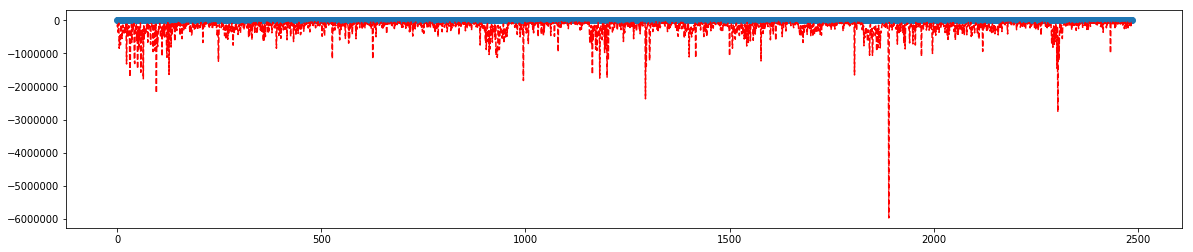

In [36]:
import matplotlib.pylab as plt
plt.figure(figsize=(20,4))
plt.scatter(range(len(df_data)),GM.score_samples(df_data))
plt.plot(GM.score_samples(df_data2),"r--")
plt.show()

### Figure 3: Plot showing anomalies in the dataset (using gaussian mixture anomaly detection)

In [37]:
# 5 most anomalous data points by log-likelihood (i.e. log probability density)
print("Top 5 most anomalous counties usung gaussian mixture anomaly detection (using normalized data):")
print(pd.Series(GM.score_samples(df_data),index=df_data.index).sort_values().head())


Top 5 most anomalous counties usung gaussian mixture anomaly detection (using normalized data):
County
Shannon, South Dakota    -115.999669
Chattahoochee, Georgia    -68.572883
Rolette, North Dakota     -68.403979
Apache, Arizona           -68.362542
Bronx, New York           -68.336914
dtype: float64


## Part 3

In [38]:
df_data.head()

,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
County,,,,,,,,,,,,,,,,,,,,,
"Autauga, Alabama",0.369815,0.746710,0.941149,0.394494,0.117919,-0.005068,0.006319,0.330898,0.363210,-0.469242,...,-0.672365,-0.352463,-0.676256,0.214550,-0.068193,0.071701,0.768581,-0.224109,1.480459,0.931500
"Baldwin, Alabama",-0.247896,0.327360,0.769062,0.394494,0.117919,-0.889187,0.473875,-0.389270,0.408623,-0.469242,...,-0.442290,-0.064894,-0.569691,-0.146772,-0.234413,-0.206669,0.898857,0.009687,0.639489,0.512595
"Barbour, Alabama",1.811140,1.445626,1.629497,1.916552,0.666371,2.205230,-1.863901,1.051066,-0.817519,-1.346336,...,1.628392,1.085381,2.201003,-0.929638,-0.607148,-0.485039,0.573167,0.711072,0.639489,0.345033
"Bibb, Alabama",0.987526,1.305842,1.457410,1.916552,0.666371,1.984200,0.286852,1.051066,-1.362472,-0.761607,...,0.362975,-0.352463,-0.143430,-0.588389,-0.158859,0.025306,0.768581,-0.457904,0.639489,1.266625
"Blount, Alabama",0.781622,1.026276,1.285323,-0.620211,0.117919,0.215962,1.128452,0.330898,-1.680360,-0.761607,...,0.017862,-0.640031,-0.569691,-0.849344,-0.244487,0.674837,0.638305,-0.691699,0.807683,2.355779


In [39]:
#Choosing IsolationForest anomaly detection method to find top 5 anomalous counties (using normalized data)
#From professor lab notes
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(df_data)

print("Top 5 most anomalous counties usung Isolation Forest anomaly detection (using normalized data):")

anom_isolation = pd.Series(clf.decision_function(df_data).squeeze(), index = df_data.index, name = "Isolation Forest").sort_values()
anom_isolation[:5]

Top 5 most anomalous counties usung Isolation Forest anomaly detection (using normalized data):


County
Shannon, South Dakota   -0.154351
Coahoma, Mississippi    -0.109960
Rolette, North Dakota   -0.102183
Apache, Arizona         -0.095533
Dallas, Alabama         -0.092982
Name: Isolation Forest, dtype: float64

## Part 4 - Comparison

In [40]:
#Bayesian using only 6 features : % Smokers, % Obese, Violent Crime Rate, 80/20 Income Ratio, %Children in Poverty and
#Average Daily PM2.5
print(exmp2.sort_values().head())

County
New York, New York                           -16.608495
San Francisco, California                    -14.827149
Rolette, North Dakota                        -14.686742
Suffolk, Massachusetts                       -14.457849
District of Columbia, District of Columbia   -13.671439
dtype: float64


In [41]:
#Kmeans on Normalized Data
res.sort_values("score",ascending=False)[:5]

,0,1,2,cluster,score
County,,,,,
"Shannon, South Dakota",27.275566,22.703873,24.946372,1,22.703873
"New York, New York",15.662466,17.232477,16.075399,0,15.662466
"Apache, Arizona",18.787789,14.336461,16.265905,1,14.336461
"Bronx, New York",15.743204,13.685857,14.348116,1,13.685857
"Kings, New York",13.455594,13.707552,13.042932,2,13.042932


In [42]:
#Gaussian on Normalized Data
print(pd.Series(GM.score_samples(df_data),index=df_data.index).sort_values().head())

County
Shannon, South Dakota    -115.999669
Chattahoochee, Georgia    -68.572883
Rolette, North Dakota     -68.403979
Apache, Arizona           -68.362542
Bronx, New York           -68.336914
dtype: float64


In [43]:
#Isolation Forest on Normalized Data
anom_isolation[:5]

County
Shannon, South Dakota   -0.154351
Coahoma, Mississippi    -0.109960
Rolette, North Dakota   -0.102183
Apache, Arizona         -0.095533
Dallas, Alabama         -0.092982
Name: Isolation Forest, dtype: float64

#Discussion

None of the 4 models give exactly the same anomaly results. New York (either Bronx or New York itself), Shannon, Rolette, and Apache, came out to be the most prominent anomalies. However they were not prominent for Isolation Forest, Bayesian, Kmeans, and Bayesian respectively.  Initially, when all the detection methods were run on un-normalized data, the results were quite similar to the one here for Bayesian Network. However, after the data is normalized, the results are pretty different, and thus hard to make some definite conclusion.

Bayesian Network detection also show San Francisco, Suffolk and District of Columbia as anomalies but it doesn't exist for any other anomaly detection models here. Kmeans shows different parts (counties) of New York as anomalies. Gaussian model shows Chaatahooche as an anomaly, but it doesn't come up as an anomaly for other detection models here. Similary, Isolation forest shows Coahoma and Dallas as anomalies (but other models here don't represent the same results).

If we generalize (by taking in consideration of all the models) here, then New York and Dakota counties are the most prominent regions to have anomalies, specifically New York. The case for New York is possible because it is one of the most affluent regions with high income disparity, homelessness, and pollution level. The case for Dakota cities is possible because both North and South Dakota in general are sparsely populated, and hence have long commute hours (drives alone). Since the climatic conditions are also harsh for Dakota (both north and south), with blizzards and tornadoes, commonly occuring phenomenons, it is likely that the region overall has low human productive overall. 

It is interesting to see that counties marked as anomalies by Bayesian Network are majorly metropolitan places (except Rolette, Suffolk). This result is likely possible because Bayesian network anomaly detection is carried on specific 6 features: % Smokers, % Obese, Violent Crime Rate, 80/20 Income Ratio, %Children in Poverty and Average Daily PM2.5. These features, specifically 80/20 Income Ratio, Average Daily PM2.5, are usually quite high for such urban counties.
Suffolk County, is the 4th most populated county in Massachusetts and hence is likely to reflect similar issues as well.

However these results are not enough to develop firm analysis and thus further investigation needs to be done.

